### Part 1. Emotion prediction model for Text. Code Explanation:  
1. **Train and Evaluate the Model**: Trains and evaluates the SVM model using `GridSearchCV` and SMOTE to balance the classes.  
2. **Save the Model, Vectorizer, and Label Encoder**: Saves the trained model, vectorizer, and label encoder using `joblib`.  
3. **Load the Model, Vectorizer, and Label Encoder**: Loads the saved model, vectorizer, and label encoder.  
4. **Function to Predict Emotion**: Defines a function `predict_emotion` that takes a sentence as input, preprocesses it using the vectorizer, makes a prediction using the loaded model, and decodes the prediction into the original emotion label.  
5. **Usage Example**: Pass a sentence to the `predict_emotion` function and get the predicted emotion.  

This workflow allows you to train, save, load, and test the model, as well as predict the emotion of a sentence.

#### Train and save the model


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   7.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   7.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   7.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   7.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   7.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   8.9s
[CV] END .......................C=0.1, gamma=0.

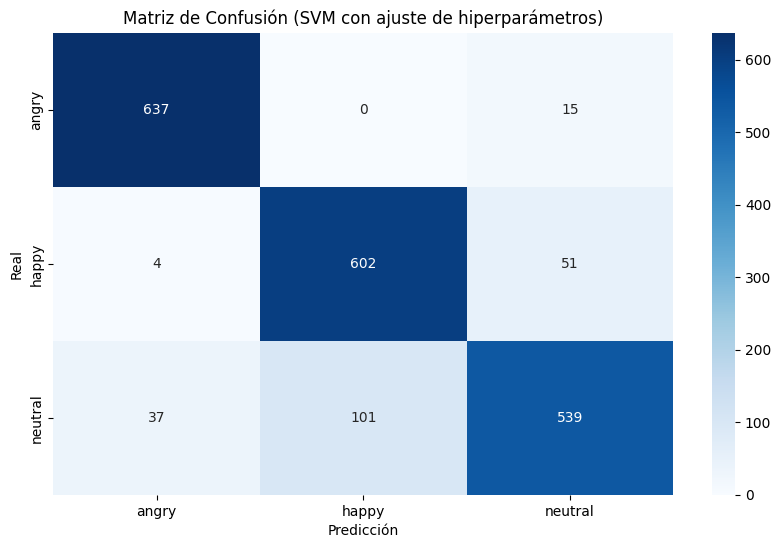

Modelo guardado como svm_model.pkl
Vectorizador guardado como tfidf_vectorizer.pkl
Codificador de etiquetas guardado como label_encoder.pkl


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# Read .tsv files
train_df = pd.read_csv('train.tsv', sep='\t')
dev_df = pd.read_csv('dev.tsv', sep='\t')

# Join dataframes
combined_df = pd.concat([train_df, dev_df], ignore_index=True)

# Rename the column ‘label “ to ”label’.
combined_df.rename(columns={'label ': 'label'}, inplace=True)

# Clear the labels in the ‘label’ column
combined_df['label'] = combined_df['label'].str.strip().str.lower()

# Changing the labels of emotions
combined_df['label'] = combined_df['label'].replace({
    'sadness': 'sad',
    'joy': 'happy',
    'anger': 'angry',
    'fear': 'fearful',
    'surprise': 'surprised',
    'others': 'neutral'
})

# Filter only relevant tags
relevant_labels = ['happy', 'angry', 'neutral']
filtered_df = combined_df[combined_df['label'].isin(relevant_labels)]

# Separate characteristics and labels
X = filtered_df['tweet']
y = filtered_df['label']

# Convert text to numeric characteristics using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Coding labels
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# Split the balanced dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_encoded, test_size=0.2, random_state=42)

# Defining the SVM model
svm_model = SVC(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Apply GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=1)
grid_search.fit(X_train, y_train)

# Best combination of hyperparameters
print("Best combination of hyperparameters:", grid_search.best_params_)

# Evaluating the model with the best hyperparameters
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

print("Classification report (SVM with hyperparameter tuning):")
print(classification_report(y_test_decoded, y_pred_decoded))

print("Confusion matrix (SVM with hyperparameter adjustment):")
print(confusion_matrix(y_test_decoded, y_pred_decoded))

#Calculate the accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"SVM model accuracy with hyperparameter fitting: {accuracy}")

# Visualise the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test_decoded, y_pred_decoded), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion matrix (SVM with hyperparameter fitting)')
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.show()

# Save the trained model
joblib.dump(best_svm_model, 'svm_model.pkl')
print("Model saved as svm_model.pkl")

# Save the vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("Vectorizer saved as tfidf_vectorizer.pkl")

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Label encoder saved as label_encoder.pkl")



#### Cargar y Testear el Modelo


In [2]:
# Load saved model
loaded_model = joblib.load('svm_model.pkl')
print("Model loaded from svm_model.pkl")

# Load saved vectoriser
vectorizer = joblib.load('tfidf_vectorizer.pkl')
print("Vectorizer loaded from tfidf_vectorizer.pkl")

# Load the saved label encoder
label_encoder = joblib.load('label_encoder.pkl')
print("Label enconder loaded from label_encoder.pkl")

# Function to predict the emotion of a sentence
def predict_emotion(phrase):
    # Preprocess the sentence
    vectorized_phrase = vectorizer.transform([phrase])
    
    # Making the prediction
    prediction = loaded_model.predict(vectorized_phrase)
    
    # Decoding the prediction
    emotion = label_encoder.inverse_transform(prediction)
    
    return emotion[0]

# Example of use
phrase = "Solo con ver con la intensidad que agitan las banderas se ve que no han quedado satisfechos los de USER Sinceramente me alegro muchísimo."
predicted_emotion = predict_emotion(phrase)
print(f"The predicted emotion for the sentence '{phrase}' is: {predicted_emotion}")

Model loaded from svm_model.pkl
Vectorizer loaded from tfidf_vectorizer.pkl
Label enconder loaded from label_encoder.pkl
The predicted emotion for the sentence 'Solo con ver con la intensidad que agitan las banderas se ve que no han quedado satisfechos los de USER Sinceramente me alegro muchísimo.' is: neutral


### Part 2. Emotion Prediction Model for Audio. Code Explanation:  

1. **Extract Features from Audio Files**: The function `extract_feature` extracts key audio features (MFCC, chroma, and mel spectrogram) from `.wav` files, ensuring a minimum length and handling potential errors.  

2. **Load and Preprocess Audio Data**: The function `load_data_expanded` loads audio samples from the RAVDESS dataset and an additional custom dataset. It maps emotions, extracts features, and encodes labels for training.  

3. **Train and Evaluate MLP Model**: A Multi-Layer Perceptron (MLP) model is trained using the extracted features. The model is then evaluated, and its accuracy is printed.  

4. **Train and Evaluate SVM Model**: A Support Vector Machine (SVM) model is optimized using `GridSearchCV` to find the best hyperparameters. The best model is selected and evaluated against the test set.  

5. **Comparison and Model Selection**: Since MLP and SVM yield similar accuracy, MLP is preferred due to its significantly lower training time.  

6. **Save and Load Models**: Both the trained MLP and SVM models, along with the label encoder, are saved using `joblib`. The models can be reloaded later for inference.  

This workflow enables efficient training, evaluation, and selection of a model for emotion prediction from audio recordings.

In [3]:
import librosa
import soundfile
import os, glob
import pickle
import numpy as np
from sklearn.neural_network import MLPClassifier

In [4]:
#Define the function for extracting the audio features
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    try:
        with soundfile.SoundFile(file_name) as sound_file:
            X = sound_file.read(dtype="float32")
            sample_rate = sound_file.samplerate
            
            # Minimum length verification
            if len(X) < 2048:  # Or other appropriate value according to your needs
                print(f"⚠️ File too short: {file_name}. This file is skipped.")
                return None
            
            if chroma:
                stft = np.abs(librosa.stft(X))
            result = np.array([])
            if mfcc:
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
                result = np.hstack((result, mfccs))
            if chroma:
                chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
                result = np.hstack((result, chroma))
            if mel:
                mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
                result = np.hstack((result, mel))
                
        return result
    except Exception as e:
        print(f"❌ Error processing {file_name}: {e}")
        return None

In [5]:
#DataFlair - Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#DataFlair - Emotions to observe
observed_emotions=['happy', 'neutral','angry']

In [6]:
from sklearn.preprocessing import LabelEncoder

# Update this dictionary if the names of the Emotions folders do not exactly match the desired emotions.
emotion_mapping = {
    'Angry': 'angry',
    'Happy': 'happy',
    'Neutral': 'neutral'
}

def load_data_expanded(test_size=0.2):
    x, y = [], []
    label_encoder = LabelEncoder()

    # Process the original dataset (RAVDESS)
    for file in glob.glob("/Users/carmona/Downloads/speech-emotion-recognition-ravdess-data/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions.get(file_name.split("-")[2])
        
        if emotion in observed_emotions:
            feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
            x.append(feature)
            y.append(emotion)
    
    # Process the new dataset (Emotions)
    for folder in emotion_mapping:
        emotion_path = f"/Users/carmona/Downloads/speech-emotion-recognition-ravdess-data/Emotions/{folder}/"
        for file in glob.glob(emotion_path + "*.wav"):
            feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
            if feature is not None:
                x.append(feature)
                y.append(emotion_mapping[folder])
   
    # Encodes the labels
    y_encoded = label_encoder.fit_transform(y)
    return train_test_split(np.array(x), y_encoded, test_size=test_size, random_state=9), label_encoder

# Uso del nuevo load_data
(x_train, x_test, y_train, y_test), label_encoder_audio = load_data_expanded(test_size=0.25)

/Users/carmona/Downloads/speech-emotion-recognition-ravdess-data/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2
  warnings.warn(


❌ Error processing /Users/carmona/Downloads/speech-emotion-recognition-ravdess-data/Emotions/Happy/03-01-03-01-02-01-20.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
❌ Error processing /Users/carmona/Downloads/speech-emotion-recognition-ravdess-data/Emotions/Neutral/03-02-01-01-01-01-24.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)


In [16]:
# Show the shape of training and test sets
print(f"Training set: {x_train.shape[0]} samples.")
print(f"Test set: {x_test.shape[0]} samples.")
print(f"Number of extracted features: {x_train.shape[1]}")

# Training of the MLP model
mlp_model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, 
                          hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
mlp_model.fit(x_train, y_train)

# Evaluation of the MLP model
y_pred_mlp = mlp_model.predict(x_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Audios - Accuracy: {accuracy_mlp}")

# Save the MLP model and the label_encoder
joblib.dump(mlp_model, 'model_emotions_audio_mlp.pkl')
joblib.dump(label_encoder_audio, 'label_encoder_audio_mlp.pkl')

Training set: 4955 samples.
Test set: 1652 samples.
Number of extracted features: 180
MLP Audios - Accuracy: 0.7784503631961259


['label_encoder_audio_mlp.pkl']

In [ ]:
# Training the SVM model for audio
param_grid_audio = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm_audio = SVC()
grid_search_audio = GridSearchCV(svm_audio, param_grid_audio, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_audio.fit(x_train, y_train)

best_svm_audio = grid_search_audio.best_estimator_
y_pred_audio = best_svm_audio.predict(x_test)

accuracy_audio = accuracy_score(y_test, y_pred_audio)
print(f"SVM Audios - Accuracy: {accuracy_audio}")

# Save the best trained SVM model for audio
joblib.dump(best_svm_audio, 'svm_model_audio_expanded.pkl')

SVM Audios - Precisión: 0.7838983050847458


['svm_model_audio_expanded.pkl']

In [12]:
# Load the MLP model for audio and its LabelEncoder
try:
    model_audio_mlp = joblib.load('model_emotions_audio_mlp.pkl')
    label_encoder_audio_mlp = joblib.load('label_encoder_audio_mlp.pkl')
    print("✅ MLP model for audio loaded correctly.")
except Exception as e:
    print(f"❌ Error loading MLP model for audio: {e}")
    model_audio_mlp = None

✅ MLP model for audio loaded correctly.


In [ ]:
# Load the SVM model for audio and its LabelEncoder
try:
    model_audio_svm = joblib.load('svm_model_audio_expanded.pkl')
    print("✅ SVM model for audio loaded correctly.")
except Exception as e:
    print(f"❌ Error loading SVM model for audio: {e}")
    model_audio_svm = None

✅ Modelo SVM de audio cargado correctamente.


### Part 3. Testing Models with Live Audio

1. **Audio Recording and Storage**: The script continuously records audio using a microphone and saves each recording as a WAV file in the `Records` folder. The filenames include timestamps to ensure uniqueness.

2. **Speech-to-Text Conversion**: The recorded audio is converted to text using Google's speech recognition API (`recognize_google`). If the word "Salir" is detected, the program stops.

3. **Text-Based Emotion Prediction**: The transcribed text is analyzed using a previously trained text emotion prediction model (`predict_emotion`). The predicted emotion is displayed.

4. **Audio-Based Emotion Prediction**: The saved audio file is processed to extract its features, which are then used as input to an MLP model trained for audio emotion detection. The predicted audio emotion is displayed.

5. **Final Emotion Decision**:
   - If the text-based emotion is "neutral," the final result is based on the audio emotion prediction.
   - If the text-based emotion is "happy" but the audio emotion is "angry," the final result is classified as "sarcasm."
   - Otherwise, the text emotion prediction is used as the final result.

6. **Error Handling**: The script manages errors such as unrecognized speech (`UnknownValueError`) or API request failures (`RequestError`).

This method ensures that the emotion detection system benefits from both text and audio predictions, prioritizing the text-based model for accuracy while incorporating audio-based predictions when needed.



In [15]:
import datetime
import speech_recognition as sr

# Create folder for the audios
output_folder = "Records"
os.makedirs(output_folder, exist_ok=True)

r = sr.Recognizer()

print("🎤 Speaking... (Say 'Salir' to finish)")

try:
    with sr.Microphone() as source:
        r.adjust_for_ambient_noise(source, duration=0.5)
        print("🟢 Listening...")

        while True:
            try:
                audio = r.listen(source)
                text = r.recognize_google(audio, language="es-ES")
                print(f"📝 Text detected: {text}")

                # Store the audio in a WAV file
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = os.path.join(output_folder, f"record_{timestamp}.wav")
                with open(filename, "wb") as f:
                    f.write(audio.get_wav_data())
                print(f"✅ Audio stored in: {filename}")

                # Predict the emotion from the text
                predicted_emotion_text = predict_emotion(text)
                print(f"🎭 Predicted emotion (text): {predicted_emotion_text}")

                # Predict the emotion from the audio with MLP
                features = extract_feature(filename)
                predicted_emotion_audio_mlp = None

                if features is not None and model_audio_mlp is not None:
                    features = features.reshape(1, -1)
                    numeric_prediction_mlp = model_audio_mlp.predict(features)
                    predicted_emotion_audio_mlp = label_encoder_audio_mlp.inverse_transform(numeric_prediction_mlp)[0]
                    print(f"🎭 Predicted emotion (audio): {predicted_emotion_audio_mlp}")

                # Determinar el resultado final
                if predicted_emotion_text == "happy" and predicted_emotion_audio_mlp == "angry":
                    resultado_final = "sarcasm"
                elif predicted_emotion_text == "neutral":
                    resultado_final = predicted_emotion_audio_mlp  # Se usa la emoción del audio
                else:
                    resultado_final = predicted_emotion_text  # Se prioriza la emoción del texto

                print(f"🔮 Resultado final: {resultado_final}")

                if text.lower() == "salir":
                    print("🔴 Finalizando...")
                    break  

            except sr.UnknownValueError:
                print("⚠️ No se entendió el audio, intenta de nuevo...")
            except sr.RequestError as e:
                print(f"❌ Error en la solicitud: {e}")

except KeyboardInterrupt:
    print("\n🔴 Finalizando...")

🎤 Speaking... (Say 'Salir' to finish)
🟢 Listening...
📝 Text detected: hoy he tenido un día súper
✅ Audio stored in: Records/record_20250307_192456.wav
🎭 Predicted emotion (text): happy
🎭 Predicted emotion (audio): neutral
🔮 Resultado final: happy
📝 Text detected: hoy he tenido un día súper bonito
✅ Audio stored in: Records/record_20250307_192502.wav
🎭 Predicted emotion (text): happy
🎭 Predicted emotion (audio): angry
🔮 Resultado final: sarcasm
📝 Text detected: salir ya está
✅ Audio stored in: Records/record_20250307_192507.wav
🎭 Predicted emotion (text): happy
🎭 Predicted emotion (audio): neutral
🔮 Resultado final: happy
📝 Text detected: salir
✅ Audio stored in: Records/record_20250307_192512.wav
🎭 Predicted emotion (text): happy
🎭 Predicted emotion (audio): happy
🔮 Resultado final: happy
🔴 Finalizando...
